---
title: "Writing Stable Diffusion from Scratch 2"
reading-time: 
date: "2023-3-15"
categories: [fastaipart2,Stable-Diffusion]
---

## Matrix multiplication from foundations

Important stuff you need to know after this lecture:  
1- Matrix Multiplication <br>
2- Numba, how to compile python code to machine code <br>
3- Frobenius Norm <br>
4- Braodcasting Rules <br>
5- expand_as , stride  <br>
6- unsqueeze , c[ None , : ] ,c[ : , None]<br>
7- c[None], c[...,None] <br>


In [ ]:
from pathlib import Path
import pickle, gzip, math, os, time, shutil, matplotlib as mpl, matplotlib.pyplot as plt

## Get data

In [ ]:
MNIST_URL='https://github.com/mnielsen/neural-networks-and-deep-learning/blob/master/data/mnist.pkl.gz?raw=true'
path_data = Path('data')
path_data.mkdir(exist_ok=True)
path_gz = path_data/'mnist.pkl.gz'

[urlretrieve](https://docs.python.org/3/library/urllib.request.html#urllib.request.urlretrieve) - (read the docs!)

In [ ]:
from urllib.request import urlretrieve
if not path_gz.exists(): urlretrieve(MNIST_URL, path_gz)

In [ ]:
!ls -l data

total 16656
-rw-r--r-- 1 root root 17051982 Mar 15 09:50 mnist.pkl.gz


In [ ]:
with gzip.open(path_gz, 'rb') as f: ((x_train, y_train), (x_valid, y_valid), _) = pickle.load(f, encoding='latin-1')

In [ ]:
lst1 = list(x_train[0])
vals = lst1[200:210]
vals

[0.0,
 0.0,
 0.0,
 0.19140625,
 0.9296875,
 0.98828125,
 0.98828125,
 0.98828125,
 0.98828125,
 0.98828125]

In [ ]:
len(lst1)

784

In [ ]:
def chunks(x, sz):
    for i in range(0, len(x), sz): yield x[i:i+sz]

In [ ]:
list(chunks(vals, 5))

[[0.0, 0.0, 0.0, 0.19140625, 0.9296875],
 [0.98828125, 0.98828125, 0.98828125, 0.98828125, 0.98828125]]

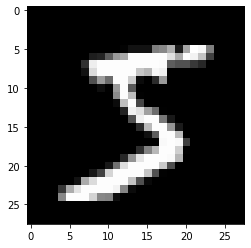

In [ ]:
mpl.rcParams['image.cmap'] = 'gray'
plt.imshow(list(chunks(lst1, 28)));

[islice](https://docs.python.org/3/library/itertools.html#itertools.islice)

In [ ]:
from itertools import islice

In [ ]:
it = iter(vals)
islice(it, 5)

<itertools.islice>

In [ ]:
list(islice(it, 5))

[0.0, 0.0, 0.0, 0.19140625, 0.9296875]

In [ ]:
list(islice(it, 5))

[0.98828125, 0.98828125, 0.98828125, 0.98828125, 0.98828125]

In [ ]:
list(islice(it, 5))

[]

In [ ]:
it = iter(lst1)
img = list(iter(lambda: list(islice(it, 28)), []))

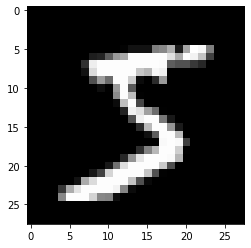

In [ ]:
plt.imshow(img);

Use this link to learn more about [iter](https://docs.python.org/3.10/library/functions.html?highlight=iter#iter)

## Matrix and tensor

In [ ]:
img[20][15]

0.98828125

In [ ]:
class Matrix:
    def __init__(self, xs): self.xs = xs
    def __getitem__(self, idxs): return self.xs[idxs[0]][idxs[1]]

In [ ]:
m = Matrix(img)
m[20,15]

0.98828125

Now we can use pytorch.

In [ ]:
import torch
from torch import tensor

In [ ]:
tensor([1,2,3])

tensor([1, 2, 3])

In [ ]:
x_train,y_train,x_valid,y_valid = map(tensor, (x_train,y_train,x_valid,y_valid))
x_train.shape

torch.Size([50000, 784])

In [ ]:
x_train.type()

'torch.FloatTensor'

[Tensor documentation](https://pytorch.org/docs/stable/tensors.html)

In [ ]:
imgs = x_train.reshape((-1,28,28))
imgs.shape

torch.Size([50000, 28, 28])

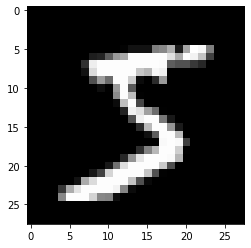

In [ ]:
plt.imshow(imgs[0]);

vector rank one tensor 
matrix is a rank 2 tensor
scalor in APL(depend of programming languages) is rank zero tensor

In [ ]:
imgs[0,20,15]

tensor(0.9883)

Use destructring again. n number of images. c is full number of colums (784)

In [ ]:
n,c = x_train.shape
y_train, y_train.shape

(tensor([5, 0, 4,  ..., 8, 4, 8]), torch.Size([50000]))

in y_train we can find min and max of it. 

In [ ]:
min(y_train),max(y_train)

(tensor(0), tensor(9))

In [ ]:
y_train.min(), y_train.max()

(tensor(0), tensor(9))

## Random numbers

Based on the Wichmann Hill algorithm used before Python 2.3.

In [ ]:
rnd_state = None
def seed(a):
    global rnd_state
    a, x = divmod(a, 30268)
    a, y = divmod(a, 30306)
    a, z = divmod(a, 30322)
    rnd_state = int(x)+1, int(y)+1, int(z)+1

In [ ]:
seed(457428938475)
rnd_state

(4976, 20238, 499)

In [ ]:
def rand():
    global rnd_state
    x, y, z = rnd_state
    x = (171 * x) % 30269
    y = (172 * y) % 30307
    z = (170 * z) % 30323
    rnd_state = x,y,z
    return (x/30269 + y/30307 + z/30323) % 1.0

In [ ]:
rand(),rand(),rand()

(0.7645251082582081, 0.7920889799553945, 0.06912886811267205)

In [ ]:
if os.fork(): print(f'In parent: {rand()}')
else:
    print(f'In child: {rand()}')
    os._exit(os.EX_OK)

In parent: 0.9559050644103264
In child: 0.9559050644103264


In [ ]:
if os.fork(): print(f'In parent: {torch.rand(1)}')
else:
    print(f'In child: {torch.rand(1)}')
    os._exit(os.EX_OK)

In parent: tensor([0.2262])
In child: tensor([0.2262])


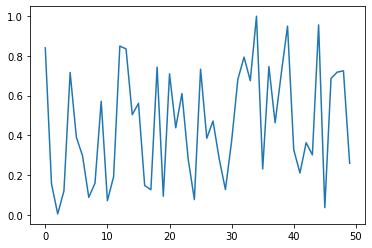

In [ ]:
plt.plot([rand() for _ in range(50)]);

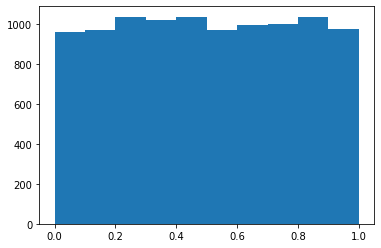

In [ ]:
plt.hist([rand() for _ in range(10000)]);

%timeit check the time of excution. 

In [ ]:
%timeit -n 10 list(chunks([rand() for _ in range(7840)], 10))

5.39 ms ± 223 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


pytorch version is faster. 

In [ ]:
%timeit -n 10 torch.randn(784,10)

86.7 µs ± 37.3 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


## Matrix multiplication

Okay, so let's move on with our from the foundations now. And so we were working on trying to at least get the start of a forward pass of a linear model or a simple multi-layer perceptron for MNIST going. And we had successfully created a basic tensor. We've got some random numbers going. So what we now need to do is we now need to be able to multiply these things together, matrix multiplication. So matrix multiplication to remind you in this case. So we're doing MNIST, right? So we've got about we're going to use a subset, let's see. Yeah, Okay. So we're going to create a matrix called m1, which is just the first five digits, So m1 will be the first five digits. So five rows and. Well, dot, dot dot dot dot dot. And then 780. What is it again. because it's 28 by 28 pixels and reflect that out. So this is our first matrix and matrix multiplication, and then we're going to multiply that by some some weights. So the weights are going to be 784 by 10 random numbers. So for every one of thes 784 pixels, each one is going to have a weight. So 784 down here, so 94 by ten. So this first column, for example, is going to tell us all the weights in order to figure out if something's a zero. And the second column will have all the weights in deciding of the probability of something. So one, so forth, assuming we just doing a linear model. And so then we're going to multiply these two matrices together. So when we multiply matrices together, we take row one of matrix one and we take column one of matrix two and we take each one in turn. So we take this one and we take this one, we multiply them together and then we take this one and this one and we multiply them together. And we do that for every element wise pair, and then we add them all up and that would give us the value for the very first cell that would go in here. That's what matrix multiplication is. Okay, so let's go ahead and create our random numbers for the weights since we're allowed to use random number generator now and for the bias, but just use a bunch of zeros to start with. So the bias is just what we're going to add to each one. And so for our matrix multiplication, we're going to be doing a little mini batch. I'm going to be doing five rows of, as we discussed, five rows of so five, five images flattened out and then multiplied by this weights matrix.


In [ ]:
torch.manual_seed(1)
weights = torch.randn(784,10)
bias = torch.zeros(10)

In [ ]:
m1 = x_valid[:5]
m2 = weights

So here are the shapes and one is five by seven, eight four as we saw, and m2 is seven, eight, four by ten. Okay, so keep those in mind. So here's a handy thing. And one touch shape contains two numbers and I want to pull them out. I want to call the I'm going to think of that as I'm going to actually think of this as like a and b rather than I wanted them to. So this is like a and b, so the number of rows in a and the number of columns in b, if I say equals and one shape that will put five in ar and 784 in ac, So I'll notice I do this a lot, this restructuring, we talked about it last week too so can do the same for m2 dot shape, put that into b rows and b columns. And so now if I write out ar,ac and br , br , you can again see the same things from the sizes. So that's a good way to kind of give us the stuff we have to look through. So here's our results.

In [ ]:
m1.shape,m2.shape

(torch.Size([5, 784]), torch.Size([784, 10]))

get matrix dimsions and put them in variables to make it readable for future looping.

In [ ]:
ar,ac = m1.shape # n_rows * n_cols
br,bc = m2.shape
(ar,ac),(br,bc)

((5, 784), (784, 10))

So here's our results. So our resultant tensor, well, we're multiplying, we're multiplying together all of these seven, eight, four things and adding them up. So the resultant tensor is going to be five by ten. And then each thing in here is the result of multiplying and adding So the result here is going to start with zeros and there is this is the result and it's going to contain ar rows, five rows and bc columns, ten columns, five coma ten. Okay, so now we have to fill that in. And so to do a matrix multiplication, so we have to first we have to go through each row one at a time and here we have that go through each row one at a time and then go through each column one at a time. And then we have to go through each pair in that row column one at a time. So it's going to be a loop in a loop in a So here's quick over each row, and here we're going to loop over each column and then here we're going to loop so each column of c, and then here we're going to leap over each column of a, which is going to be the same as the number of rows of b, which we can see here. I say ac or br they are seven, eight, four. They're the same.
So it wouldn't matter whether we day, ac or br, so then our result for that row and that column, we have to add onto it the product of i,k in the first matrix by k,j in the second matrix. So k, it's going up through those seven, eight, four. And so we're going to go across the columns and down so across the rows and down the columns, it's going to go across the row where it goes down this column. So here is the world's most naive, slow, uninteresting matrix multiplication. And if we run it, okay, it's done something we have successfully hopefully successfully multiplied the matrices m1 and m2.It's a little hard to read this, I find because because punch cards used to be 80 columns wide. We still assume screens 80 columns wide.
Everything defaults to 80 wide, which is ridiculous, but you can easily change it. So if you say sit print options, you can choose your own line width. Oh, you can say it's five by ten. We did it before. So if we change the line width, okay, that's much easier to rate. Now we can see here the five rows and here are the ten columns for that matrix multiplication. I tend to always put this at the top of my notebooks and you can do the same thing for numpy as well. So what I'd like to do this is really important is when I'm working on code, particularly numeric code, I like to do it all step by step and Jupiter. And then what I do is once I've got it working is a copy all the cells that have implemented that and I paste them and then I select them all and I hit shift+m to merge. 
Get rid of anything that prints out stuff I don't need. And then I put a header on the top, give it a function name, and then I select the whole lot and I hit control or f right square bracket and I've turned it into a function, but I still keep the stuff above it. So I can see all the step by step stuff for learning about it later. And so that's what I've done here to create this function. And so this function does exactly the same things we just did, and we can see how long it takes to run by using  %time. And it took about half a second, which gosh, that's a long time to generate such a small matrix. This is just to do five MNIST digits. So that's not going to be great. We're going to have to speed that up. I'm actually quite surprised at how slow that is because there's only 39,200. So, you know, if you look at the how, we've got a loop within a loop within a loop, it's doing 39,200 of these. So Python. Yeah, Python. When you're just doing python, it is it is slow. So we can't we can't do that. That's why we can't just write Python.

In [ ]:
t1 = torch.zeros(ar, bc)
t1.shape

torch.Size([5, 10])

Go through each row one at a time (5), then each column one at a time (10) and then go through each pair(784). 
go accross the rows , down the column multiply and add. 
 t1[i,j] += m1[i,k] * m2[k,j]

In [ ]:
for i in range(ar):         # 5
    for j in range(bc):     # 10
        for k in range(ac): # 784
            t1[i,j] += m1[i,k] * m2[k,j]

Default is 80 columns wide because of punch cards and we still do that. (Talking about legacy and network effect , haha)

In [ ]:
t1

tensor([[-10.9417,  -0.6844,  -7.0038,  -4.0066,  -2.0857,  -3.3588,   3.9127,
          -3.4375, -11.4696,  -2.1153],
        [ 14.5430,   5.9977,   2.8914,  -4.0777,   6.5914, -14.7383,  -9.2787,
           2.1577, -15.2772,  -2.6758],
        [  2.2204,  -3.2171,  -4.7988,  -6.0453,  14.1661,  -8.9824,  -4.7922,
          -5.4446, -20.6758,  13.5657],
        [ -6.7097,   8.8998,  -7.4611,  -7.8966,   2.6994,  -4.7260, -11.0278,
         -12.9776,  -6.4443,   3.6376],
        [ -2.4444,  -6.4034,  -2.3984,  -9.0371,  11.1772,  -5.7724,  -8.9214,
          -3.7862,  -8.9827,   5.2797]])

In [ ]:
t1.shape

torch.Size([5, 10])

This is only to show data more readable. 

In [ ]:
torch.set_printoptions(precision=2, linewidth=140, sci_mode=False)
t1

tensor([[-10.94,  -0.68,  -7.00,  -4.01,  -2.09,  -3.36,   3.91,  -3.44, -11.47,  -2.12],
        [ 14.54,   6.00,   2.89,  -4.08,   6.59, -14.74,  -9.28,   2.16, -15.28,  -2.68],
        [  2.22,  -3.22,  -4.80,  -6.05,  14.17,  -8.98,  -4.79,  -5.44, -20.68,  13.57],
        [ -6.71,   8.90,  -7.46,  -7.90,   2.70,  -4.73, -11.03, -12.98,  -6.44,   3.64],
        [ -2.44,  -6.40,  -2.40,  -9.04,  11.18,  -5.77,  -8.92,  -3.79,  -8.98,   5.28]])

Do this on the top of the notebook and make it easier.

In [ ]:
import numpy as np
np.set_printoptions(precision=2, linewidth=140)

For numerical programming , Jeremy recommend doing stuff line by line , check the results and dimensions and then when it works , copy all the cells and paste them after those cell and select them all and hit shift+M to merge cells get ride of everything that prints out stuff you dont need put a header on the top (def ....), select the rest of the code and hit control + ] now you have the function. Keep the same none function code above to remember what did you do and how you get there.

In [ ]:
def matmul(a,b):
    (ar,ac),(br,bc) = a.shape,b.shape
    c = torch.zeros(ar, bc)
    for i in range(ar):
        for j in range(bc):
            for k in range(ac): c[i,j] += a[i,k] * b[k,j]
    return c

How long does it take to run ? Man it too much. It is o(n^3) and it is so slow

In [ ]:
%time _=matmul(m1, m2)

CPU times: user 771 ms, sys: 748 µs, total: 772 ms
Wall time: 774 ms


In [ ]:
ar*bc*ac

39200

## Numba

But there is something that kind of lets this write Python we could instead use Numba.Numba is a system that takes python and turns it into basically into machine code and it's amazingly easy to do. You can basically take a function and write and @ngit on top. And what it's going to do is it's going to look the first time you call this function, it's going to compile it down to machine code and will run much more quickly. So what I've done here is I've taken the innermost loop. So just looping through and adding up all these. So I start at zero, go through and add up all those just two vectors and return it, which is called a dot product. And linear algebra, so call it dot and so Numba only works with numpy, it doesn't work with PyTorch. So we're just going to use arrays instead of tensers for a moment. Now have a look at this. If I try to do a dot product of one, two, three and two, three, four, it's pretty easy to do. It took a fifth of a second, which sounds terrible, but the reason it took a fifth of a second is because that's actually how long it took to compile this and run it. Now that it's compiled the second time, it just has to call it it's now 21 microseconds. And so that's actually very fast. So with Numba we can basically make Python run at C speed. So now the important thing to recognize is if I replace this loop in Python with a called a dot which is running in machine code, then we now have one two loops running in python not three. So our 448 MS, let's make sure if I run it, run that matmul that should be close to my t1 one. t1 is what we got before.

And so when I'm refactoring or performance improving or whatever, I always like to put every step in the notebook and then test. So this test close comes from fastcore.test and it just checks. The two things are very similar. They might not be exactly the same because of floating point differences, which is fine. Okay, our matmul is working correctly, or at least it's doing the same thing it did before. So if we now run it, it's taking 268 micro second, versus 448 milliseconds. So it's taking, you know, about 2000 times faster just by changing the one in my loop. So really all we've done is we've had @ngit to make it 2000 times faster, so Numba is well worth knowing about. I can make your Python code very, very fast. Okay, let's keep making it faster. So we're going to use stuff again, which kind of goes back APL. And a lot of people say that learning APL is the thing that's taught them more about programing than anything else. So it's probably worth considering learning APL And let's just look at these various things. You got a is ten six minus four. So remember at APL, we don't say equals, equals actually means equals. Funny enough we to say set two, we use this arrow and it's, this is a list of ten, six, four and then b is 287. Okay. And we're going to add them up a plus b, So what's going on here? So it's really important that you can think of a symbol like a as representing a tensor or an array. APL calls them arrays, pytorch call them tensors, Numpy calls them arrays. They're the same thing. So this is a single that contains a bunch of numbers. This is a single thing that contains a bunch of numbers. This is an operation that applies to arrays or tensors. Now what it does is it works what's called elsment-wise. It takes each pair ten and two, and that's them together. Each pair six and eight, add them together. This is element wise addition and Fred is asking in the chat, how do you put in these symbols? If you just mouse over any of them, it will show you how to write it and the one you want is the one at the very bottom, which is the one where it says prefix. Now the prefix is the backtick character. So here it's saying prefix hyphen gives us times. So we've had hyphen. So I've of a backtick dash b is a times b for example. So yeah, they all have shortcut keys which you learn pretty quickly. I find, and there's a fairly consistent kind of system for those shortcut keys too. All right, So we can do the same thing in PyTorch. 


In [ ]:
from numba import njit

In [ ]:
@njit
def dot(a,b):
    res = 0.
    for i in range(len(a)): res+=a[i]*b[i]
    return res

In [ ]:
from numpy import array

In [ ]:
%time dot(array([1.,2,3]),array([2.,3,4]))

CPU times: user 479 ms, sys: 145 ms, total: 624 ms
Wall time: 563 ms


20.0

In [ ]:
%time dot(array([1.,2,3]),array([2.,3,4]))

CPU times: user 34 µs, sys: 6 µs, total: 40 µs
Wall time: 44.3 µs


20.0

Now only two of our loops are running in Python, not three:

In [ ]:
def matmul(a,b):
    (ar,ac),(br,bc) = a.shape,b.shape
    c = torch.zeros(ar, bc)
    for i in range(ar):
        for j in range(bc): c[i,j] = dot(a[i,:], b[:,j])
    return c

In [ ]:
m1a,m2a = m1.numpy(),m2.numpy()

This is the test. 

In [ ]:
from fastcore.test import *

In [ ]:
test_close(t1,matmul(m1a, m2a))

2000 time faster. We change inner most loop. 

In [ ]:
%timeit -n 50 matmul(m1a,m2a)

455 µs ± 16.9 µs per loop (mean ± std. dev. of 7 runs, 50 loops each)


So we can do the same thing in PyTorch. It's a little bit more verbose. PyTorch, which is one reason I often like to do my mathematical fiddling around in APL. I can often do it with less boilerplate, which means I can spend more time thinking, you know, I can see everything on the screen at once. I don't have to spend as much time trying to like ignore the tensor around bracket square bracket dot com, blah blah. It's all cognitive load, which I'd rather ignore. But anyway, it does the same thing so I can say a plus b work exactly like APL. So here's an interesting example. I can go a less than (a < b).float().mean(). So let's try that one over here less than b. So this is a really important idea, which I think was invented by Ken Iverson, the APL guy, which is that true and false represented zero and one. And because they're represented by zero and one, we can do things to them. We can add them up and subtract and so forth. That's a really important idea. So in this case, I want to take the main of them, and I'm going to tell you something amazing, which is that in APL there is no function called mean. Why not? That's because we can write the mean function, which so that's four letters mean and we can write the mean function from scratch with four characters. I'll show you. Here's the whole mean function we're going to create a function called mean, and the mean is equal to the sum of a list divided by the of the list. So this here is some divided by count. And so I have now to find a new function called mean, which calculates the mean, mean of a is less than b, there we go. And so, you know in practice, I'm not sure why people would even bother defining a function called mean because it's just as easy to actually write it's implementation in APL, in numpy or whatever a python.
It's going to take a lot more than four letters to implement mean. So anyway, you know, it's a math notation and so being a math notation we can do a lot with little, which I find out folks, I can say everything going on at once anyway. Okay, so that's how we do the same thing in pytouch. And again, you can say that the less than in both cases, operating element wise. Okay, So a is less than b is saying ten is less than two six is less than eight four is less than seven and gives us back each of those trues and faleses as zeros and onces and according to our YouTube chat, had just exploded as it should. This is why APL is. Yeah life changing. 


## Elementwise ops

[TryAPL](https://tryapl.org/)

In [ ]:
a = tensor([10., 6, -4])
b = tensor([2., 8, 7])
a,b

(tensor([10.,  6., -4.]), tensor([2., 8., 7.]))

Elementwise addition

In [ ]:
a + b

tensor([12., 14.,  3.])

Check lecture for awesome implementation of mean. 

In [ ]:
(a < b).float().mean()

tensor(0.67)

Rank two tensor , aka Matrix. 

In [ ]:
m = tensor([[1., 2, 3], [4,5,6], [7,8,9]]); m

tensor([[1., 2., 3.],
        [4., 5., 6.],
        [7., 8., 9.]])

Okay, let's now go up to higher rank. So this here is a rank one tensor. So a rank one tensor means it's a list of things, it's a vector, it's where else a rank two tensor. It's like a list of lists. They all have to be the same length lists, or it's like a rectangular bunch of numbers. And we call it in math, we call it a matrix. So this is how we can create a tensor containing one, two, three, four, five, six, 789. And you can see also, like, what I like to do is I want to print out the thing I just created after I created it. Two ways to do it. You can say put an enter and then write m and that's going to do that. Or if you want to put it all in the same line, that works too. You just use a semicolon. Neither one is better than the other. They're just different. So we could do the same thing in APL. Of course in APL it's going to be much easier. So we're going to define a matrix called m which is going to be a three by 3 by 3 tensor containing the numbers from 1 to 9. Okay. And there we go. That's done it in APL, a three by three tensor containing the numbers from 1 to 9. A lot of these ideas from APL you'll find have made their way into other programing languages. For example, if you use GO you might recognize this. This is the iota character and go uses the word iota to spell it out in a somewhat similar way. A lot of these ideas from APL have found themselves into math notation and in other languages. It's been around since the late fifties. Okay, so here's a bit of fun. We're going to learn about a new thing that looks kind of crazy code for Frobenius  Norm and we'll use that from time to time as we're doing modeling. And here's a definition of a four Frobenius norm. It's the sum over all of the rows and columns of a matrix, and we're going to take each one and square it. They're going to add them up and they're going to take the square root. 

And so to implement that in  pytouch is as simple as (m*m).sum().sqrt(). So this looks like a pretty complicated thing when you kind of look at it. At first it looks like a lot of squiggly business or if you said this thing here you might be like, what on earth is that? Well, now you know, it's just a square, some square root. So again, we could do the same thing in APL. So let's do so in APL. We want the okay, so we got a case called S.F. Now it's interesting, Apple does this a little bit differently. So dot some by default in PyTorch sums over everything. And if you want to sum over just one dimension, you have to pass in a dimension keyword for very good reasons. APL is the opposite. It just comes across rows or just down columns. So actually we have to say sum up the flattened out version of the Matrix and say flattened out. He is comma. So his sum up the flattened out version of the Matrix. Okay, so that's our S.F.. Oh, Oh, sorry. And the Matrix is meant to be m times m There you go. So that's the same thing. Sum up the flattened out and by a matrix and another interesting thing about APL is it always is read right to left. There's no such thing as operator precedence, which makes life a lot easier. Okay, then we take the square root of that. There isn't a square root function, so we have to do to the power of 0.5 and there we go. Same thing. All right, You got the idea. Yes. A very interesting question here from Marabou or other bars for norm or absolute value. And I like answer, which is the norm, is the same as the absolute value for scalar. So in this case, you can think of it as absolute value and it's kind of not needed because it's being squared anyway. But yes, in this case the norm. Well, in every case for a scale, the norm is the absolute value, which is kind of a cute discovery when you realize it. So thank you for pointing that out. See the. All right. So this is just fiddling around a little bit to kind of get a sense of how these things work. So really importantly, you can index into a matrix and you'll say rows first and then columns.

# Frobenius norm:

$$\| A \|_F = \left( \sum_{i,j=1}^n | a_{ij} |^2 \right)^{1/2}$$

*Hint*: you don't normally need to write equations in LaTeX yourself, instead, you can click 'edit' in Wikipedia and copy the LaTeX from there (which is what I did for the above equation). Or on arxiv.org, click "Download: Other formats" in the top right, then "Download source"; rename the downloaded file to end in `.tgz` if it doesn't already, and you should find the source there, including the equations to copy and paste. This is the source LaTeX that I pasted to render the equation above:

```latex
$$\| A \|_F = \left( \sum_{i,j=1}^n | a_{ij} |^2 \right)^{1/2}$$
```

In [ ]:
sf = (m*m).sum()
sf

tensor(285.)

In [ ]:
sf.sqrt()

tensor(16.88)

So really importantly, you can index into a matrix and you'll say rows first and then columns. And if you say column, it means all the columns. So if I say row two, here it is row two all the columns. Sorry, this is row two. Two sets of zero, APL starts at one, all the columns that's going to be seven, eight, nine. And you can say I often use comma to print out multiple things and I don't have to say print in Jupyter. It's kind of assumed. And so this is just a quick way of printing out the second row. And then here every row column two. So here is every row of column two and here you can see three, six, nine. So one thing very useful to recognize is that for tensors of higher rank than one, such as a matrix, any trailing colomns are optional. 
So you say this here m2 that's the same as m2 comma column. It's really important to remember. so m2 you can say the result is the same. So that means row two every column. Okay, so now with all that in place, we've got quite an easy way. We don't need a number anymore. We can multiply so we can get rid of that innermost loop. So we're going to get rid of this loop because this is just multiplying together all of the corresponding rows of a with or without sorry, all the corresponding columns of row a With all the corresponding rows of column of b, And so we can just use an element wise operation for that. So here is the i th row of s and here is the j th column of b. And so those are both as we've seen just vectors and therefore we can do an element wise multiplication of them and then some of them up and the same as a dot product. So that's handy. And so again, what do test close. Okay, it's the same great. And again you'll see we kind of did all of experimenting first, right, to make sure we understood how it all worked and then put it together. And then if we time it 661 microseconds. Okay. So it's interesting. It's actually slower than it really shows you how good number is, but it's certainly a hell of a lot better our 450 milliseconds. But we know we're using something that's kind of a lot more general now. This is exactly the same as dot as we've discussed. So we could just use torture, dot, dot, dot, dot, I suppose I should say. And if we run that okay, a little faster, it's still interestingly, this is still slower than the Numba, which is quite amazing actually. All right. So that's that one was not exactly a speed up, but it's kind of more general. It's just nice. Now we're going to get something into something really fun, which is broadcasting. And broadcasting is about what if you have arrays with different shapes? So what's the shape? The shape is the number of or the number of rows and columns or the number of or, as you say, faces rows and columns and so forth. So for example, the shape of m is three by three. So what happens if you multiply or add or do operations to tensors of different shapes? Well, one very simple one, which is if you've got a rank one tensor a vector, then you can use any operation with a scalar and it broadcasts that scalar across the tensor. So A\a is greater than zero is exactly the same as saying a is greater than tensor zero comma zero comma zero. So it's basically copying that across three times. That's not literally making a copy in memory, but it's acting as if we had said that. And this is the most simple version of broadcasting, okay, It's broadcasting the zero across the ten and the six and the negative four and. APL does exactly the same thing.
a is less than five, so 0 0 1 first time idea. Okay, so we can do plus with a scalar and we can do exactly the same thing with higher than rank one. So two times a matrix is just going to do two. It's going to be broadcast across all the rows and all the columns. Okay, now gets interesting. So broadcasting dates back to APL, but a really interesting idea is that we can broadcast not just scaler, but we can broadcast vectors across matrices or broadcast any kind of lower ranked tensor across higher ranked tenses or even broadcast together together two tenses of the same rank, but different shapes and a really powerful way. And as I was exploring this, I was trying to I love doing this kind of computer archeology yesterday to find out where the hell this comes from. And it actually turns out from this email message in 1995 that the idea actually comes from a language that I'd never heard of Yorick, which still apparently exists, is Yorick. And so Yorick has talks about broadcasting and controllability. So what happened is this this very obscure language that's this very powerful idea.
And NumPy has, has has happily stolen the idea from Yorick that allows us to broadcast together tensors that don't appear to match. So let me give an example. Here's a ten second c, that's a vector. It's a rank 1 tensor at ten, 20, 30, and here's a ten second m, which is a matrix we see in this one before, and one of them is shape three comma three, the other is shape three and. Yet we can add them together. Now, what's happened when we added it together? Well, what's happened is ten, and then 10 20 30 got added to four, five, six and then 10 20 30  got added to seven, eight, nine. And hopefully you can see this looks quite familiar. Instead of broadcasting a scalar over a higher rank tensor, this is broadcasting a vector across every row of a matrix and it works both ways. So we can say c plus m gives us exactly the same thing. And so let me explain what's actually happening here. The trick is to know about this somewhat obscure method called expandas I would expand as does this. This creates a new thing called t, which contains exactly the same thing as c, but expanded it kind of copied over so it has the same shape as m. So here's what t looks like now. t contains exactly the same thing as c does, but it's got three copies of it now. And you can say we can definitely add t to m because they match shapes, right? So we can say m plus t, we know we can play m plus t because we've already learned that you can do element wise operations on two things that have matching shapes. Now, by the way, this thing t didn't actually create three copies. Check this out. If we call t.storage, it tells us what's actually in memory. It actually just contains the numbers ten, 20, 30 but it doesn't really clever trick. It has a stride of zero across the rows and a size of three comma three. And so what that means is that it acts as if it's a three by three matrix, and each time it goes to the next row, it actually stays exactly where it is. And this idea of strides is the trick which Numpy and PyTorch and so forth use for all kinds of things where you basically can create, you know, very efficient ways to to do things like expanding or to kind of jump over things and stuff like that, you know, switch between columns and rows, stuff like that.
Anyway, the important thing here for us to recognize is that we didn't actually make a copy. This is totally efficient. That's all going to be run in C code very fast. So remember this expandas is critical. This is the thing that will teach you to understand how broadcasting works, which is really important for implementing deep learning algorithms or any kind of linear algebra on any python system because the Numpy rules are used exactly the same in jacks, in TensorFlow and PyTorch and so forth. Now I'll show you a little trick, which is going to be very important in a moment. If we take C, which remember is a vector containing ten, 20, 30 and we say c.unsqueeze(0), then it changes the shape from 3 to 1 comma three. So it changes from a vector of length three to a matrix of one row by three columns. This would turn out to be very important in a moment, and you can see how it's printed. It's printed out with two square brackets. Now, I never use one squeeze because I much prefer doing something more flexible, which is if you index into an axis with a special value, none also known as np dot new axis, it does exactly the same thing. It inserts a new axis here. So here we'll get exactly the same thing. One row by all the columns, straight columns. So this is exactly the same as saying unsqueeze. So this inserts a new unit axis. This is a unit axis, a single row. And this dimension and this does the same thing. So these are the same. So we could do the same thing and say unsqueeze(1), which means now we're going to unsqueeze into the first dimension. So that means we now have three rows and one column.

So the shape here, the shape is inserting a unit axis in position one. three rows and one column. And so we can do exactly the same thing here. Give us every row and a new unit, axis and position one same thing. Okay, So those two are exactly the same. So this is how we create a matrix with one row. This is how we create a matrix with one column [None, :] vs       [: , None] or unsqueeze. We don't have to say as we've done before, non comma colon because you remember trailing colons optional. So therefore just say None is also going to give you a row matrix one. Right. Matrix. This is a little trick here. If you say dot dot, dot that means all of the dimensions and so dot, dot, dot comma None will always insert a unit axis at the end, regardless of what rank a tensor is. So yes, so None and NP new axis mean exactly the same thing. NP new axis is actually a synonym for None if you've ever used that. I always use None because why not. Short and simple. So here's something interesting. If we go see colon comma, None. So let's go and check out what's C colonn comma None looks like C colonm common. None is a column. But if we say expandas which is three by three, then it's going to take that 10 20 30 column and replicate it. 10, 20, 30, 10, 20, 30,, 10, 20, 30, So we could add. So remember like, well, remember, I'll explain that when you say matrix plus C colon common none, it's basically going to do this dot expandas for you, so if I want to add this matrix here to m, I don't need to say don't expandas I just write this at m+c[:,None]. And so this is exactly the same as doing m plus c, but now, rather than adding the vector to each row, it's adding the vector to each column.
c plus 10, 20, 30, 10, 20, 30, 10, 20, 30. So that's a really simple way that we now get kind of for free, thanks to this really nifty notation, this initial approach that came from Yorick. So here you can see m plus c None comma column is adding 10, 20, 30 to each row and m plus c column comma None is adding 10 20 30 to each column. All right. So that's the basic like hand-waving version. So let's look at like what are the rules and how does it work? Okay, so c[None,:] is one by three, c[:,None]. What if we multiplyc [None,:] by  c[:,None]. Well it's going to do if you think about it, but you definitely should because thinking is very helpful. What is going on here? Okay, so what happens if we go c[None,:] times c[:,None]. So what it's going to have to do is it's going to have to take this 10, 20, 30 column vector or three by one matrix, and it's going to have to make it work across each of these rows. So what it does is expands it to be 10 20 30, ,  10 20 30  ,  10 20 30  So it's going to do it just like this and then it's going to do the same thing for, c[None,:]. So that's going to become three rows of 10, 20, 30. So we're going to end up with three rows of 10, 20, 30 times three columns of 10, 20, 30, which gives us our answer. And so this is going to do an outer product. So it's very nifty that you can actually do an outer product without any special, you know, functions or anything just using broadcasting. And it's not just out of products. You can do outer Boolean operations and this kind of stuff comes up all the time. Right now, remember, you don't need the comma colon, so get rid of it. So this is showing us all the places where it's greater than it's kind of an outer and outer boolean, if you want to call it that. So this is super nifty and you can do all kinds of tricks with this because it runs very, very fast. So this is going to be accelerated in C.

In [ ]:
m[2,:],m[:,2]

(tensor([7., 8., 9.]), tensor([3., 6., 9.]))

In [ ]:
m[2]

tensor([7., 8., 9.])

We can use elementwise operation and get ride of inner loop. 

In [ ]:
def matmul(a,b):
    (ar,ac),(br,bc) = a.shape,b.shape
    c = torch.zeros(ar, bc)
    for i in range(ar):
        for j in range(bc): c[i,j] = (a[i,:] * b[:,j]).sum()
    return c

Test to see they are the same. 

In [ ]:
test_close(t1,matmul(m1, m2))

In [ ]:
%timeit -n 50 _=matmul(m1, m2)

1.31 ms ± 71.4 µs per loop (mean ± std. dev. of 7 runs, 50 loops each)


Now that we wrote it , we can use equivalent of pytorch. (torch.dot)

In [ ]:
def matmul(a,b):
    (ar,ac),(br,bc) = a.shape,b.shape
    c = torch.zeros(ar, bc)
    for i in range(ar):
        for j in range(bc): c[i,j] = torch.dot(a[i,:], b[:,j])
    return c

In [ ]:
test_close(t1,matmul(m1, m2))

In [ ]:
%timeit -n 50 _=matmul(m1, m2)

999 µs ± 67.1 µs per loop (mean ± std. dev. of 7 runs, 50 loops each)


The term **broadcasting** describes how arrays with different shapes are treated during arithmetic operations.

From the [Numpy Documentation](https://docs.scipy.org/doc/numpy-1.10.0/user/basics.broadcasting.html):

    The term broadcasting describes how numpy treats arrays with 
    different shapes during arithmetic operations. Subject to certain 
    constraints, the smaller array is “broadcast” across the larger 
    array so that they have compatible shapes. Broadcasting provides a 
    means of vectorizing array operations so that looping occurs in C
    instead of Python. It does this without making needless copies of 
    data and usually leads to efficient algorithm implementations.
    
In addition to the efficiency of broadcasting, it allows developers to write less code, which typically leads to fewer errors.

*This section was adapted from [Chapter 4](http://nbviewer.jupyter.org/github/fastai/numerical-linear-algebra/blob/master/nbs/4.%20Compressed%20Sensing%20of%20CT%20Scans%20with%20Robust%20Regression.ipynb#4.-Compressed-Sensing-of-CT-Scans-with-Robust-Regression) of the fast.ai [Computational Linear Algebra](https://github.com/fastai/numerical-linear-algebra) course.*

### Broadcasting with a scalar

In [ ]:
a

tensor([10.,  6., -4.])

Simplest way of broadcasting. 

In [ ]:
a > 0

tensor([ True,  True, False])

How are we able to do `a > 0`?  0 is being **broadcast** to have the same dimensions as a.

For instance you can normalize our dataset by subtracting the mean (a scalar) from the entire data set (a matrix) and dividing by the standard deviation (another scalar), using broadcasting.

Other examples of broadcasting with a scalar:

plus 

In [ ]:
a + 1

tensor([11.,  7., -3.])

In [ ]:
m

tensor([[1., 2., 3.],
        [4., 5., 6.],
        [7., 8., 9.]])

multiply

In [ ]:
2*m

tensor([[ 2.,  4.,  6.],
        [ 8., 10., 12.],
        [14., 16., 18.]])

### Broadcasting a vector to a matrix

Although broadcasting a scalar is an idea that dates back to APL, the more powerful idea of broadcasting across higher rank tensors [comes from](https://mail.python.org/pipermail/matrix-sig/1995-November/000143.html) a little known language called [Yorick](https://software.llnl.gov/yorick-doc/manual/yorick_50.html).

We can also broadcast a vector to a matrix:

lower rank to higher rank. Same rank with different shapes. 

In [ ]:
c = tensor([10.,20,30]); c

tensor([10., 20., 30.])

In [ ]:
m

tensor([[1., 2., 3.],
        [4., 5., 6.],
        [7., 8., 9.]])

In [ ]:
m.shape,c.shape

(torch.Size([3, 3]), torch.Size([3]))

add c to each row of m (Matrix). 

In [ ]:
m + c

tensor([[11., 22., 33.],
        [14., 25., 36.],
        [17., 28., 39.]])

In [ ]:
c + m

tensor([[11., 22., 33.],
        [14., 25., 36.],
        [17., 28., 39.]])

Trick is we create t so then t could add to m.

In [ ]:
t = c.expand_as(m)

In [ ]:
t

tensor([[10., 20., 30.],
        [10., 20., 30.],
        [10., 20., 30.]])

In [ ]:
m + t

tensor([[11., 22., 33.],
        [14., 25., 36.],
        [17., 28., 39.]])

We don't really copy the rows, but it looks as if we did. In fact, the rows are given a *stride* of 0.

In [ ]:
t.storage()

 10.0
 20.0
 30.0
[torch.storage.TypedStorage(dtype=torch.float32, device=cpu) of size 3]

We only have one line , so we did not copy , make the code efficient. 

In [ ]:
t.stride(), t.shape

((0, 1), torch.Size([3, 3]))

You can index with the special value [None] or use `unsqueeze()` to convert a 1-dimensional array into a 2-dimensional array (although one of those dimensions has value 1).

This is how we create matrix with one row , [None, :]

In [ ]:
c.unsqueeze(0), c[None, :]

(tensor([[10., 20., 30.]]), tensor([[10., 20., 30.]]))

Use unsqueeze to change the shape. We can use this trick for broadcasting. 

In [ ]:
c.shape, c.unsqueeze(0).shape

(torch.Size([3]), torch.Size([1, 3]))

This is how we create matrix with one column , [ : , None], easier than unsqueeze but the same. 

In [ ]:
c.unsqueeze(1), c[:, None]

(tensor([[10.],
         [20.],
         [30.]]), tensor([[10.],
         [20.],
         [30.]]))

In [ ]:
c.shape, c.unsqueeze(1).shape

(torch.Size([3]), torch.Size([3, 1]))

You can always skip trailling ':'s. And '...' means '*all preceding dimensions*'

we can avoid : and say c[None].

In [ ]:
c[None].shape,c[...,None].shape

(torch.Size([1, 3]), torch.Size([3, 1]))

In [ ]:
c[:,None].expand_as(m)

tensor([[10., 10., 10.],
        [20., 20., 20.],
        [30., 30., 30.]])

basicly does .expand_as for you. This adding the vector to each column.

In [ ]:
m + c[:,None]

tensor([[11., 12., 13.],
        [24., 25., 26.],
        [37., 38., 39.]])

This adding the vector to each row. 

In [ ]:
m + c[None,:]

tensor([[11., 22., 33.],
        [14., 25., 36.],
        [17., 28., 39.]])

So here are the rules. Okay? When you operate on two arrays or tensors, numpy and pytorch will compare their shapes. Okay, so remember the shape. This is a shape. You can tell us a shape because we said shape and it goes from right to left. So that's the traveling dimensions and it checks by the dimensions are compatible. Now they're compatible if they're equal, right? So for example, if we say m times, m, then those two shapes are compatible because the because in each case the it's going to be three, right? So they're going to be equal. So if that if the shape in that dimension is equal, they're compatible, or if one of them is one and if one of them is one, then dimension is broadcast to make it the same size as the other. So that's why the outer product worked. We had a one by three times, a three by one, and so this one got copied three times to make this long and this one got copied three times to make it this long. Okay, so those are the rules. So the arrays don't have to have the same number of dimensions. So this is an example that comes up all the time. Let's say you've got a 256 by 256 by three array of tensor of RGP values. So you've got an image, in other words, a three color image, and you want to normalize. So you want to scale each color in the image by a different value. So this is how we normalize colors. So one way is to you could multiply or divide or whatever, multiply the image by a one dimensional array with three values. So you've got a 1D array. So that's just three. 
Okay. And then the image is 256 by 256 by three, and we go right to left and we check, are they the same? We say, Yes, they are. And then we keep going left and we say, are they the same? And if missing, we act as if it's one. And if we get keep going, if it's missing, we act as if it's one, this is going to be the same as doing one by one by three. And so this is going to be broadcast. This three, three elements will be brought broadcast over all to 256, but 266 pixels. So this is a super fast and convenient and nice way of normalizing image data with a single expression. And this is exactly how we do it in the fast day library. In fact. So we can use this to dramatically speed up our matrix multiplication. Let's just grab a single digit just for simplicity. And I really like doing this in Jupyter notebooks. And if you if you build Jupyter notebooks to explain stuff that you've learned in this course or ways that you can apply it, consider doing this for your readers, but add a lot more prose. I haven't added prose here because I want to use my voice. If I, for example, in our book that we published, it's all written in notebooks and there's a lot more prose, obviously. But like really, I'd like to show every example all along the way using simple as possible.



### Broadcasting Rules

In [ ]:
c[None,:]

tensor([[10., 20., 30.]])

In [ ]:
c[None,:].shape

torch.Size([1, 3])

In [ ]:
c[:,None]

tensor([[10.],
        [20.],
        [30.]])

In [ ]:
c[:,None].shape

torch.Size([3, 1])

3 rows times 3 column. This do outer product and other stuff like this. 

In [ ]:
c[None,:] * c[:,None]

tensor([[100., 200., 300.],
        [200., 400., 600.],
        [300., 600., 900.]])

outer boolean. This run fast. 

In [ ]:
c[None] > c[:,None]

tensor([[False,  True,  True],
        [False, False,  True],
        [False, False, False]])

In [ ]:
m*m

tensor([[ 1.,  4.,  9.],
        [16., 25., 36.],
        [49., 64., 81.]])

When operating on two arrays/tensors, Numpy/PyTorch compares their shapes element-wise. It starts with the **trailing dimensions**, and works its way forward. Two dimensions are **compatible** when
It goes from right to left.
- they are equal, or
- one of them is 1, in which case that dimension is broadcasted to make it the same size

Arrays do not need to have the same number of dimensions. For example, if you have a `256*256*3` array of RGB values, and you want to scale each color in the image by a different value, you can multiply the image by a one-dimensional array with 3 values. Lining up the sizes of the trailing axes of these arrays according to the broadcast rules, shows that they are compatible:

    Image  (3d array): 256 x 256 x 3
    Scale  (1d array):             3
    Result (3d array): 256 x 256 x 3

The [numpy documentation](https://docs.scipy.org/doc/numpy-1.13.0/user/basics.broadcasting.html#general-broadcasting-rules) includes several examples of what dimensions can and can not be broadcast together.

## Matmul with broadcasting

 So let's just grab a single digit. So here's the first digit. So its shape is it's a 784 long vector. Okay. And remember that our weight matrix is 784 by ten. Okay. So if we say digit colon coma None dot shape, then that is a 784 by one row matrix. Okay. So there's our matrix. And so if we then take that 784 by one and expandas m2, it's going to be the same shape as our weight matrix. So it's copied our image data for that digit across all of the ten  vectors, representing the ten kind of linear projections we're doing for our linear model. And so that means that we can take the digit colon comma a None so 784 by one and multiply it by the weights. And so that's going to get us back 784 by 10 so what it's doing, remember, is it's basically looping through each of these 10, 784 long vectors. And for each one of them it's multiplying it by this digit. So that's exactly what we want to do in our matrix multiplication. So originally we had when I originally most recently I should say, we had this dot product where we were actually looping over j, which was the columns of b, So we don't have to do that anymore because we can do it all at once by doing exactly what we just did so we can take the ith and all the columns and add a access to the end. And then just like we did here, multiply it by b and then .sum(). And so that is again exactly the same thing.

In [ ]:
digit = m1[0]
digit.shape,m2.shape

(torch.Size([784]), torch.Size([784, 10]))

In [ ]:
digit[:,None].shape

torch.Size([784, 1])

In [ ]:
digit[:,None].expand_as(m2).shape

torch.Size([784, 10])

In [ ]:
(digit[:,None]*m2).shape

torch.Size([784, 10])

In [ ]:
def matmul(a,b):
    (ar,ac),(br,bc) = a.shape,b.shape
    c = torch.zeros(ar, bc)
    for i in range(ar):
#       c[i,j] = (a[i,:] * b[:,j]).sum()      # previous version
        c[i]   = (a[i,:,None] * b).sum(dim=0) # broadcast version
    return c

In [ ]:
test_close(t1,matmul(m1, m2))

In [ ]:
%timeit -n 50 _=matmul(m1, m2)

185 µs ± 54.5 µs per loop (mean ± std. dev. of 7 runs, 50 loops each)


That is another metrics, multiplication, doing it using broadcasting. Now this is like a tricky to get your head around. And so if you haven't done this kind of broadcasting before, it's a really good time to pause the video and look carefully at each of these four cells before and understand what did I do there, Why did I do it? What am I showing you? And then experiment with trying to and so remember that we started with m1 zero, right? So just like we have here, a[i , so that's why we've got, i comma colon comma None because this digit is actually m1 zero. So this is like m1 zero colon None. So this line is doing exactly the same thing as this here plus the sum. So let's check if this matmul is the same as it used to be, yet still working and the speed of it. Okay, not bad. So 137 microseconds. So we've now gone from a time from 500 milliseconds to about point 1 milliseconds. Funnily enough, my MacBook Air is an m2, whereas this Mac mini is an m1 that's a little bit slower. So my error it was a bit faster than 0.1 milliseconds. So overall we've got about a 5000 times speed improvement. So that is pretty exciting. And since it's so fast now, there's no need to use a mini batch anymore. If you remember, we used a mini batch of five images, but now we can actually use the whole dataset so fast. So now we can do the whole data set. There it is. We've now got 15,000 by ten, which is what we want. And so it's taking us only 656 milliseconds now to do the whole dataset. So this is actually getting to a point now where we could start to create and train some simple models in a reasonable enough time. So that's good news. All right. I think that's probably a good time to take a break. We don't have too much more of this to go, but I don't want to keep you guys up too late. So hopefully you learned something interesting about broadcasting today. I cannot overemphasize how widely useful is in all deep learning in machine learning code. It comes up all the time. It's basically our number one most critical kind of foundational operation. So, yeah, take your time practicing it. And also good luck with your diffusion homework from the first half of the lesson. Thanks for joining us and I'll see you next time.



In [ ]:
tr = matmul(x_train, weights)
tr

tensor([[  0.96,  -2.96,  -2.11,  ..., -15.09, -17.69,   0.60],
        [  6.89,  -0.34,   0.79,  ..., -17.13, -25.36,  16.23],
        [-10.18,   7.38,   4.13,  ...,  -6.73,  -6.79,  -1.58],
        ...,
        [  7.40,   7.64,  -3.50,  ...,  -1.02, -16.22,   2.07],
        [  3.25,   9.52,  -9.37,  ...,   2.98, -19.58,  -1.96],
        [ 15.70,   4.12,  -5.62,  ...,   8.08, -12.21,   0.42]])

In [ ]:
tr.shape

torch.Size([50000, 10])

In [ ]:
%time _=matmul(x_train, weights)

CPU times: user 1.92 s, sys: 1.61 ms, total: 1.93 s
Wall time: 2.3 s
